<p style="text-align:center; font-weight:bolder; font-size: 2em">
    L6-Tutorial-Regression
</p>
<p style="text-align:center; font-family:courier; font-size: 110%">
    <br>25 Feb 2019
    <br>COM5508 Media Data Analytics
    <br>Department of Media and Communication
    <br>City University of Hong Kong
</p>

# Loading DataFrame from CSV

In [1]:
# import packages
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

# read data from file
df = pd.read_csv('./movie_metadata.csv')

# handle missing values and duplicates
df = df.dropna()
df = df.drop_duplicates()

In [2]:
# bin dependent variables
dv = df["imdb_score"]
bins = [0, 2, 4, 6, 8, 10]; bin_labels = [1, 2, 3, 4, 5]
dv_binned = pd.cut(dv, bins, right = False, labels = bin_labels)
df['imdb_score_binned'] = dv_binned

In [3]:
# select numerical features
numerical_feature_list = list(set(df._get_numeric_data().columns) - set(['imdb_score']))
print(numerical_feature_list)

['movie_facebook_likes', 'budget', 'actor_2_facebook_likes', 'gross', 'duration', 'director_facebook_likes', 'num_voted_users', 'aspect_ratio', 'cast_total_facebook_likes', 'num_user_for_reviews', 'facenumber_in_poster', 'actor_1_facebook_likes', 'num_critic_for_reviews', 'title_year', 'actor_3_facebook_likes']


In [8]:
# select all categorical features
categorical_feature_list = ['country', 'language', 'color', 'director_name', 'actor_1_name', 'actor_2_name',\
                            'actor_3_name', 'content_rating', 'title_year', 'aspect_ratio', 'facenumber_in_poster']

# Baseline of Classification

In [6]:
# use the original group ratio as a baseline for prediction
print("Original Group Ratio:")
print(df['imdb_score_binned'].value_counts() / len(df['imdb_score_binned']))

Original Group Ratio:
4    0.665592
3    0.255708
5    0.056406
2    0.021488
1    0.000806
Name: imdb_score_binned, dtype: float64


# Decision Tree
API Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

User Guide: https://scikit-learn.org/stable/modules/tree.html

The scikit-learn package uses an optimised version of the CART algorithm but does not support categorical variables for now. -- Thus, we need to transform categorical features to dummy variables.

## Dummy Coding Categorical Features

In [9]:
# dummy coding all categorical features (except genres as a movie may have more than one genre tag)
df_clean = df[numerical_feature_list]
for feature in categorical_feature_list:
    df_clean = pd.concat([df_clean, pd.get_dummies(df[feature], prefix = feature)], axis = 1)

# extract all possible values in 'genres' 
liste_genres = set()
for s in df['genres'].str.split('|'):
    liste_genres = set().union(s, liste_genres)
liste_genres = list(liste_genres)

# dummy coding genres for each movie
for genre in liste_genres:
    df_clean[genre] = df['genres'].str.contains(genre).apply(lambda x:1 if x else 0)

In [16]:
# define X and y as input
X = df_clean
y = np.array(df['imdb_score_binned'])

In [25]:
# import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# define a classifier
clf = DecisionTreeClassifier(criterion='entropy') # make random_state fixed

# fit the model using X and y
clf.fit(X, y)

# print the score of the model
print(clf.score(X, y))

1.0


In [26]:
# import cross_val_score to conduct cross validation
from sklearn.model_selection import cross_val_score

# print the mean of a 10-fold cross validation score using X and y
print(np.mean(cross_val_score(clf, X, y, cv=10)))

0.6916756160899906


## Visualize the Decision Tree

Once trained, we can export the tree in Graphviz format using the export_graphviz exporter. If you use the conda package manager, the graphviz binaries and the python package can be installed with

`conda install python-graphviz`

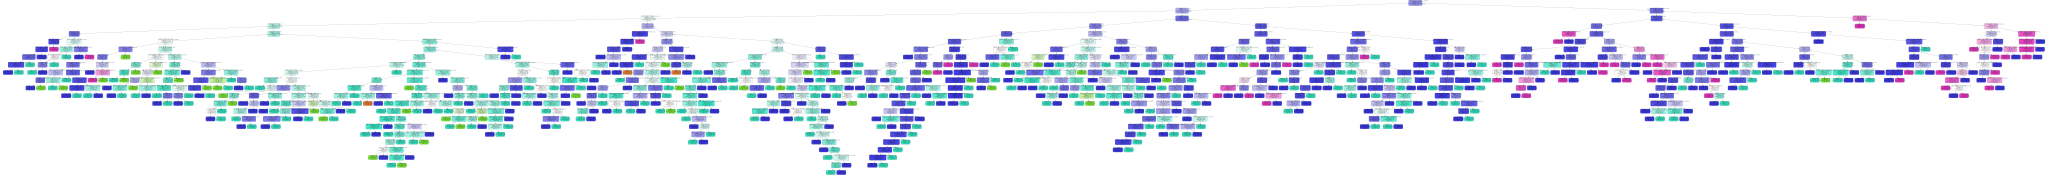

In [27]:
# use export_graphviz to export the information of the tree
from sklearn.tree import export_graphviz

dot_data = export_graphviz(clf, out_file=None, 
             feature_names=X.columns,  
             class_names=['1,', '2', '3', '4', '5'],
             filled=True, rounded=True,  
             special_characters=True)  

# use graphviz to visualize the tree
import graphviz 
graph = graphviz.Source(dot_data)

# you can also save the figure to ./cart_tree.pdf to see it more clearly
# graph.render("cart_tree")

# show the figure in jupyter notebook
graph

# Artificial Neural Network

API Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
User Guide: https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [19]:
# import MLPClassifier
from sklearn.neural_network import MLPClassifier

# define a classifier
clf = MLPClassifier(activation='logistic', solver='sgd')

# fit the model using X and y
clf.fit(X, y)

# print the score of the model
print(clf.score(X, y))

0.6655922643029815


In [20]:
# print the mean of a 10-fold cross validation score using X and y
print(np.mean(cross_val_score(clf, X, y, cv=10)))

# !!! this cell requires highly intensive computation and relatively huge time consumption

0.6655952286598008


# Comparison Models

Use another two models to make comparison with decision tree and artificial neural network

In [23]:
# import LogisticRegression
from sklearn.linear_model import LogisticRegression

# define a classifier
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# print the mean of a 10-fold cross validation score using X and y
print(np.mean(cross_val_score(clf, X, y, cv=10)))

# !!! this cell requires highly intensive computation and relatively huge time consumption

0.6326829159175923


In [22]:
# import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# define a classifier
clf = RandomForestClassifier(criterion='entropy')

# print the mean of a 10-fold cross validation score using X and y
print(np.mean(cross_val_score(clf, X, y, cv=10)))

0.7314240623928189
